# 📊 Phase 3: Revenue Forecasting & EDA – Mercado Livre E-Commerce Dataset

## 🧠 Project Objective

In this Phase 3 capstone project, we analyze real-world e-commerce data from **Mercado Livre**, a leading Latin American online marketplace.  
The goal is to perform **Exploratory Data Analysis (EDA)** and implement **revenue forecasting models** to help the business anticipate future trends and make better strategic decisions.

---

## ✅ Key Tasks Covered:

- Cleaned and merged multiple raw datasets (orders, payments, customers, products)
- Analyzed monthly and category-wise revenue trends
- Built two forecasting models:
  - **Holt-Winters Exponential Smoothing (Statsmodels)**
  - **Linear Regression (Scikit-learn)**
- Evaluated forecast accuracy using **MAE** and **RMSE**
- Visualized actual vs forecasted revenue for the next 24 months
- Compared model performance and recommended the best-fit forecasting approach

---

## 🛠 Tools & Libraries Used:
`Pandas`, `NumPy`, `Matplotlib`, `Seaborn`, `Statsmodels`, `Scikit-learn`

---

> 📌 *This notebook represents a complete end-to-end business data analysis and forecasting pipeline using Python. Ideal for real-world portfolio showcase.*



In [36]:
import pandas as pd
import os

# Folder path
folder_path = r"C:\Users\PC\Downloads\Mercado Livre - ecom\Mercado Livre - ecom"

# Load only required datasets
customers = pd.read_csv(os.path.join(folder_path, 'customers_dataset.csv'))
orders = pd.read_csv(os.path.join(folder_path, 'orders_dataset.csv'))
order_items = pd.read_csv(os.path.join(folder_path, 'order_items_dataset.csv'))
payments = pd.read_csv(os.path.join(folder_path, 'order_payments_dataset.csv'))
products = pd.read_csv(os.path.join(folder_path, 'products_dataset.csv'))
category_translation = pd.read_csv(os.path.join(folder_path, 'product_category_name_translation.csv'))

# Optional but useful
reviews = pd.read_csv(os.path.join(folder_path, 'order_reviews_dataset.csv'))
sellers = pd.read_csv(os.path.join(folder_path, 'sellers_dataset.csv'))

In [37]:
import pandas as pd

# Step 1: Merge orders and payments on 'order_id'
orders_payments = pd.merge(orders,payments, on='order_id', how='inner')

# Step 2: Convert purchase timestamp to datetime
orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp'])

# Step 3: Extract month from timestamp
orders_payments['month'] = orders_payments['order_purchase_timestamp'].dt.to_period('M')

# Step 4: Group by month to get total revenue
monthly_revenue = orders_payments.groupby('month')['payment_value'].sum().reset_index()

# Step 5: Convert period back to timestamp for plotting
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()

# Show the output
monthly_revenue.head()



,month,payment_value
0,2016-09-01,252.24
1,2016-10-01,59090.48
2,2016-12-01,19.62
3,2017-01-01,138488.04
4,2017-02-01,291908.01


In [38]:
# convert purchase date into date format
orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp'], errors='coerce')


# Check the structure
print(orders_payments[['order_id', 'order_purchase_timestamp', 'payment_value']].head())

                           order_id order_purchase_timestamp  payment_value
0  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33          18.12
1  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33           2.00
2  e481f51cbdc54678b7cc49136f2d6af7      2017-10-02 10:56:33          18.59
3  53cdb2fc8bc7dce0b6741e2150273451      2018-07-24 20:41:37         141.46
4  47770eb9100c2d0c44946d9cf07ec65d      2018-08-08 08:38:49         179.12


In [33]:
# Step 1: Merge orders and payments on 'order_id'
orders_payments = pd.merge(orders, payments, on='order_id', how='inner')

# Step 2: Convert purchase timestamp to datetime
orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp'])

# Step 3: Extract month from timestamp
orders_payments['month'] = orders_payments['order_purchase_timestamp'].dt.to_period('M')

# Step 4: Group by month to get total revenue
monthly_revenue = orders_payments.groupby('month')['payment_value'].sum().reset_index()

# Step 5: Convert period back to timestamp for plotting
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()

# extract month_name 

monthly_revenue['month_name'] = monthly_revenue['month'].dt.strftime('%B')

month_order=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_revenue['month_name']=pd.Categorical(monthly_revenue["month_name"],categories=month_order,ordered= True)

# Merge orders with payments
order_payments = pd.merge(orders, payments, on='order_id')

# Add customer_unique_id
order_payments = pd.merge(order_payments, customers[['customer_id', 'customer_unique_id']], on='customer_id')

# Group by month to get total revenue and unique orders
monthly_data = orders_payments.groupby('month').agg({
    'payment_value': 'sum',          # Total revenue per month
    'order_id': 'nunique'            # Total unique orders per month
}).reset_index()

# Convert period to timestamp for plotting
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Calculate AOV (Average Order Value)
monthly_data['AOV'] = monthly_data['payment_value'] / monthly_data['order_id']


# Step 1: Merge products with category translations
products = pd.merge(products, category_translation, on='product_category_name', how='left')

# Step 2: Merge order_items with products to get product category
order_product = pd.merge(order_items, products[['product_id', 'product_category_name_english']], on='product_id', how='left')

# Step 3: Merge with payments to get revenue
order_product_payment = pd.merge(order_product, payments[['order_id', 'payment_value']], on='order_id', how='left')


# Merge with orders table to bring timestamp
category_revenue = pd.merge(order_product_payment, orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# Convert timestamp to datetime format
category_revenue['order_purchase_timestamp'] = pd.to_datetime(category_revenue['order_purchase_timestamp'])

# Extract month

category_revenue['month'] = category_revenue['order_purchase_timestamp'].dt.to_period('M')

# Group by category and month
monthly_category_rev = category_revenue.groupby(['product_category_name_english', 'month'])['payment_value'].sum().reset_index()

# Convert month back to timestamp for plotting
monthly_category_rev['month'] = monthly_category_rev['month'].dt.to_timestamp()

# Get top 5 categories by total revenue
top_categories = monthly_category_rev.groupby('product_category_name_english')['payment_value'].sum().nlargest(5).index

# Filter data for top categories
top_category_data = monthly_category_rev[monthly_category_rev['product_category_name_english'].isin(top_categories)]




In [39]:
# convert purchase date into date format
orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp'], errors='coerce')

# Convert timestamp to month format
orders_payments['month'] = orders_payments['order_purchase_timestamp'].dt.to_period('M')

# Group by month to calculate total revenue
monthly_revenue = orders_payments.groupby('month')['payment_value'].sum().reset_index()

# Convert Period to datetime for plotting
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()

# Preview result
print(monthly_revenue.head())


       month  payment_value
0 2016-09-01         252.24
1 2016-10-01       59090.48
2 2016-12-01          19.62
3 2017-01-01      138488.04
4 2017-02-01      291908.01


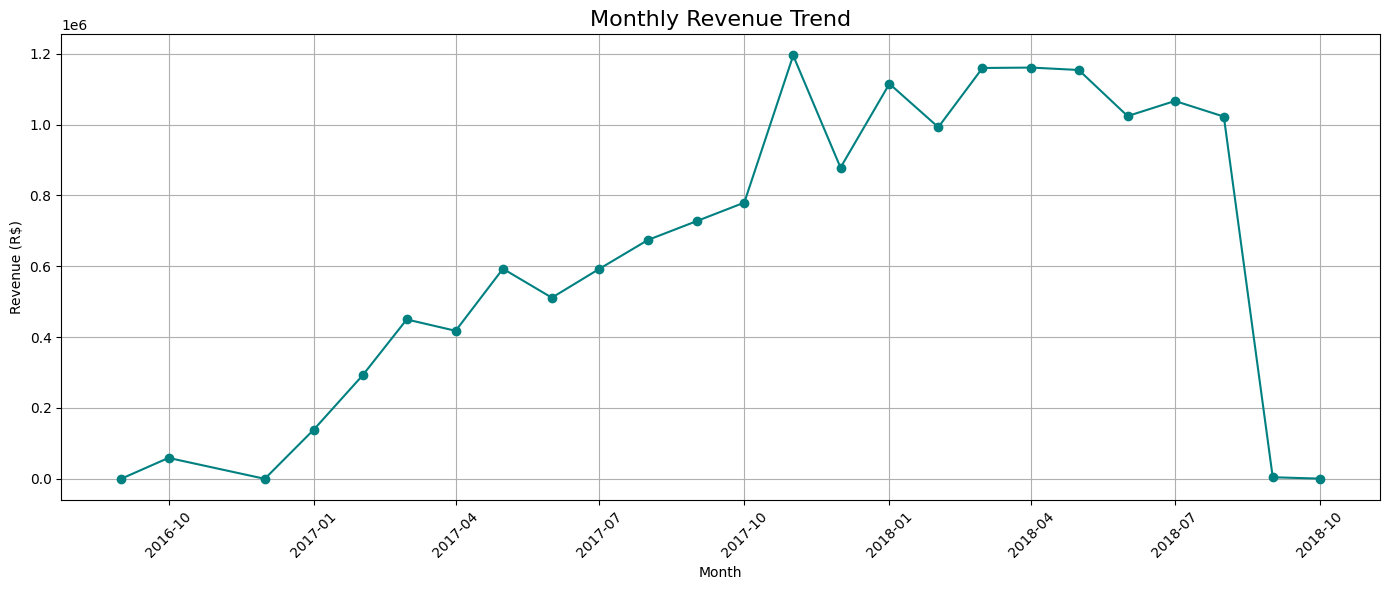

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Merge orders and payments on 'order_id'
orders_payments = pd.merge(orders,payments, on='order_id', how='inner')

# Step 2: Convert purchase timestamp to datetime
orders_payments['order_purchase_timestamp'] = pd.to_datetime(orders_payments['order_purchase_timestamp'])

# Step 3: Extract month from timestamp
orders_payments['month'] = orders_payments['order_purchase_timestamp'].dt.to_period('M')

# Step 4: Group by month to get total revenue
monthly_revenue = orders_payments.groupby('month')['payment_value'].sum().reset_index()

# Step 5: Convert period back to timestamp for plotting
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()

# Show the output
monthly_revenue.head()


plt.figure(figsize=(14, 6))
plt.plot(monthly_revenue['month'], monthly_revenue['payment_value'], marker='o', color='teal')
plt.title('Monthly Revenue Trend', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

 Observations from Monthly Revenue Trend:

Revenue started very low in 2016.

A sharp increase began from early 2017.

Revenue consistently grew month-on-month through 2017.

The highest peak was in November 2017 (11,94,882.80 BRL).

After November 2017, revenue remained high but slightly fluctuating into 2018.

In September 2018, a sudden heavy drop happened (4,439.54 BRL), followed by another big drop in October 2018 (589.67 BRL).

Seasonality: Small signs of increased sales around November–December period (possibly festive season?).

Overall Trend: Strong upward trend from 2017 until mid-2018, then a sharp decline.

EDA Observations on Monthly Revenue Trend
Revenue was very low during the initial months of 2016.

A sharp growth phase started from early 2017, showing strong business expansion.

Consistent month-on-month growth was observed throughout 2017.

The highest revenue was recorded in November 2017 at BRL 11,94,882.80, likely driven by festive or promotional seasons.

Post-peak, revenue remained high but fluctuating across 2018.

A significant revenue drop was observed in September 2018 (BRL 4,439.54) and October 2018 (BRL 589.67).

Seasonal Patterns: Noticeable spikes around November–December, indicating potential seasonal influence (e.g., Black Friday, Christmas sales).

Overall Trend: Clear upward trajectory from 2017 to mid-2018, followed by a sharp decline toward late 2018.

In [41]:
# Top 5 revenue months

top_months = monthly_revenue.sort_values(by="payment_value",ascending=False).head(5)
print("Top 5 Months")
print(top_months)


# Bottom 5 revenue months 

bottom_months = monthly_revenue.sort_values(by="payment_value",ascending=True).head(5)
print("\nBottom 5 Months")
print(bottom_months)

Top 5 Months
        month  payment_value
13 2017-11-01     1194882.80
18 2018-04-01     1160785.48
17 2018-03-01     1159652.12
19 2018-05-01     1153982.15
15 2018-01-01     1115004.18

Bottom 5 Months
        month  payment_value
2  2016-12-01          19.62
0  2016-09-01         252.24
24 2018-10-01         589.67
23 2018-09-01        4439.54
1  2016-10-01       59090.48


C:\Users\PC\AppData\Local\Temp\ipykernel_6372\267288738.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seasonality.index,y=seasonality.values,palette='viridis')


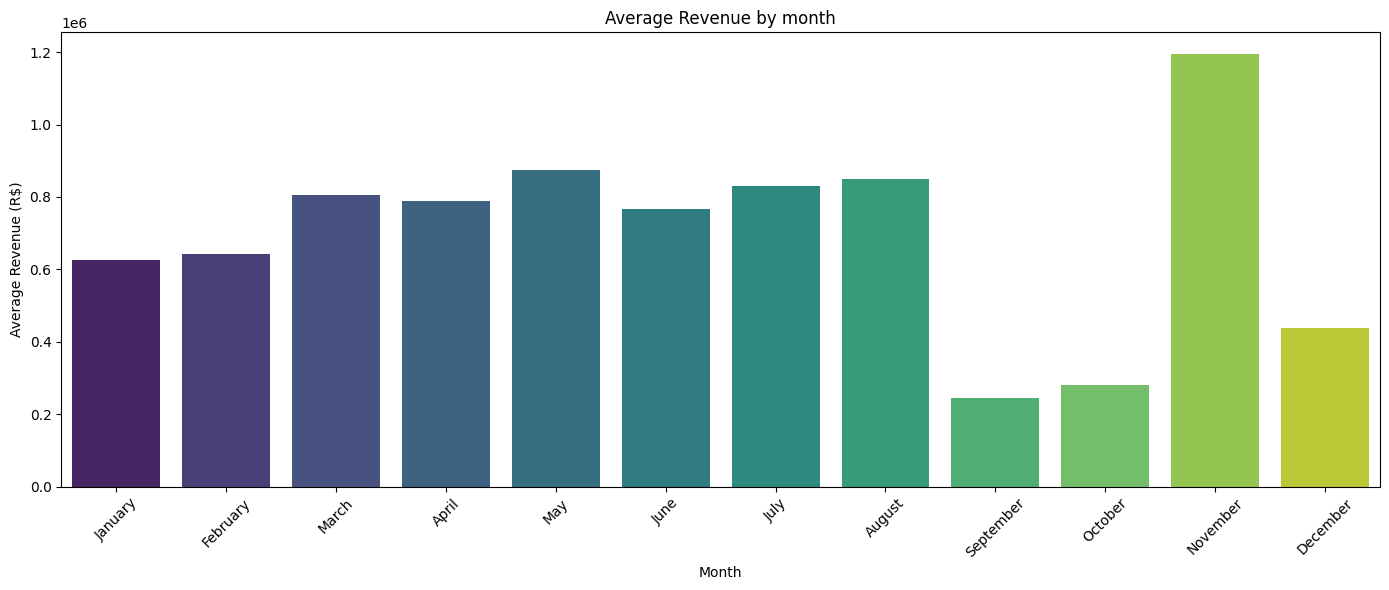

In [42]:
import seaborn as sns

# extract month_name 

monthly_revenue['month_name'] = monthly_revenue['month'].dt.strftime('%B')

# group by month name (all the years)

seasonality = monthly_revenue.groupby('month_name')['payment_value'].mean().reindex([
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
])
seasonality

# plot

plt.figure(figsize=(14,6))
sns.barplot(x=seasonality.index,y=seasonality.values,palette='viridis')
plt.title('Average Revenue by month')
plt.ylabel('Average Revenue (R$)')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

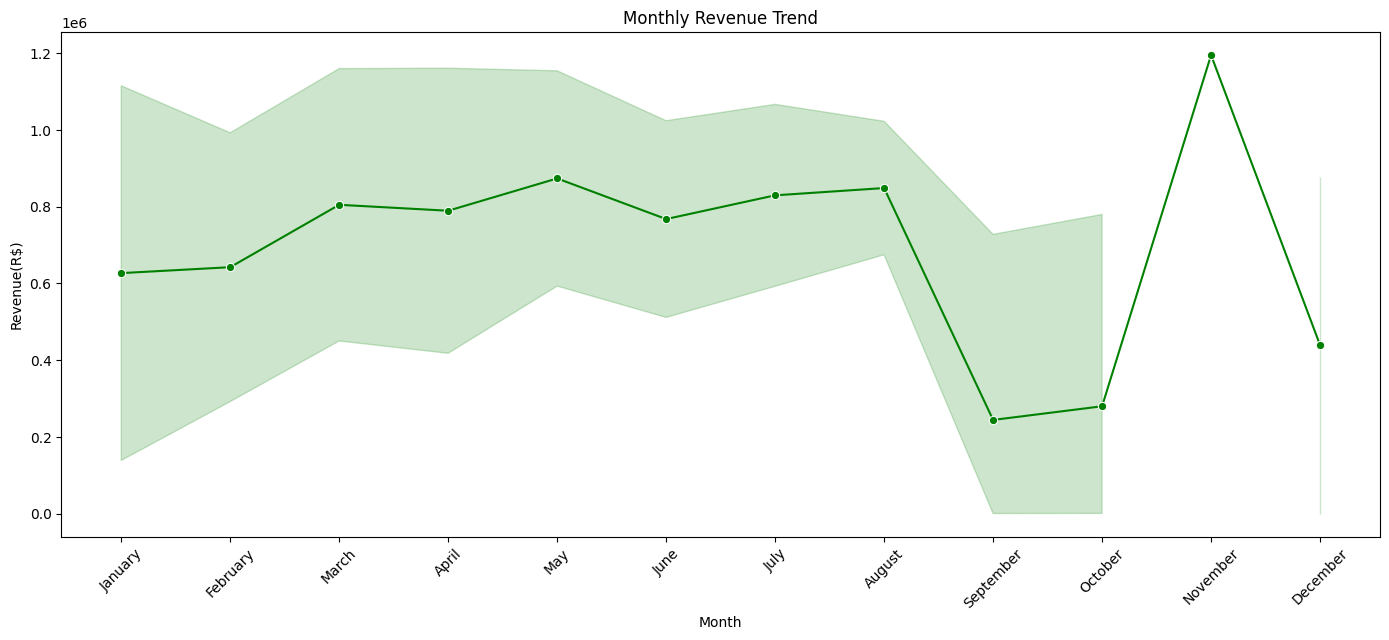

In [43]:
month_order=[
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]
monthly_revenue['month_name']=pd.Categorical(monthly_revenue["month_name"],categories=month_order,ordered= True)
monthly_revenue


plt.figure(figsize=(14,6))
sns.lineplot(x=monthly_revenue['month_name'],y=monthly_revenue['payment_value'],marker='o',color='green')
plt.title("Monthly Revenue Trend")
plt.xlabel('Month')
plt.ylabel('Revenue(R$)')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [10]:
# Merge orders with payments
order_payments = pd.merge(orders, payments, on='order_id')

# Add customer_unique_id
order_payments = pd.merge(order_payments, customers[['customer_id', 'customer_unique_id']], on='customer_id')

# Group by unique customer to get CLV
clv = order_payments.groupby('customer_unique_id')['payment_value'].sum().reset_index()
clv.rename(columns={'payment_value': 'CLV'}, inplace=True)

clv.head()


,customer_unique_id,CLV
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89


In [11]:
# Sort by top CLV
clv = clv.sort_values(by='CLV', ascending=False)

clv.head(10)  # Top 10 customers by CLV

,customer_unique_id,CLV
3826,0a0a92112bd4c708ca5fde585afaa872,13664.08
26456,46450c74a0d8c5ca9395da1daac6c120,9553.02
81961,da122df9eeddfedc1dc1f5349a1a690c,7571.63
44447,763c8b1c9c68a0229c42c9fc6f662b93,7274.88
82807,dc4802a71eae9be1dd28f5d788ceb526,6929.31
26205,459bef486812aa25204be022145caa62,6922.21
95805,ff4159b92c40ebe40454e3e6a7c35ed6,6726.66
24121,4007669dec559734d6f53e029e360987,6081.54
35070,5d0a2980b292d049061542014e8960bf,4809.44
89687,eebb5dda148d3893cdaf5b5ca3040ccb,4764.34


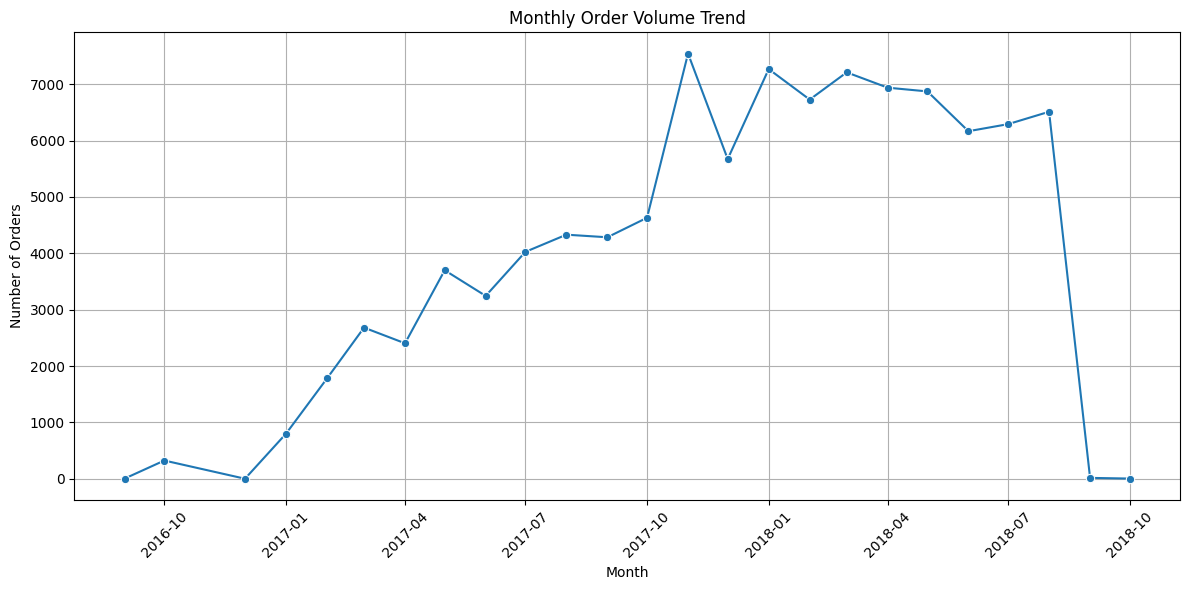

In [12]:
# ============================
# Order Trend EDA - Step 1
# ============================
import seaborn as sns

# Convert purchase timestamp to datetime format (if not already)
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Extract month and year
orders['month'] = orders['order_purchase_timestamp'].dt.to_period('M')

# Group by month to count total orders per month
monthly_orders = orders.groupby('month')['order_id'].count().reset_index()
monthly_orders.rename(columns={'order_id': 'total_orders'}, inplace=True)

# Convert month back to timestamp for plotting
monthly_orders['month'] = monthly_orders['month'].dt.to_timestamp()

# Plotting monthly order volume
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_orders, x='month', y='total_orders', marker='o')
plt.title('Monthly Order Volume Trend')
plt.xlabel('Month')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


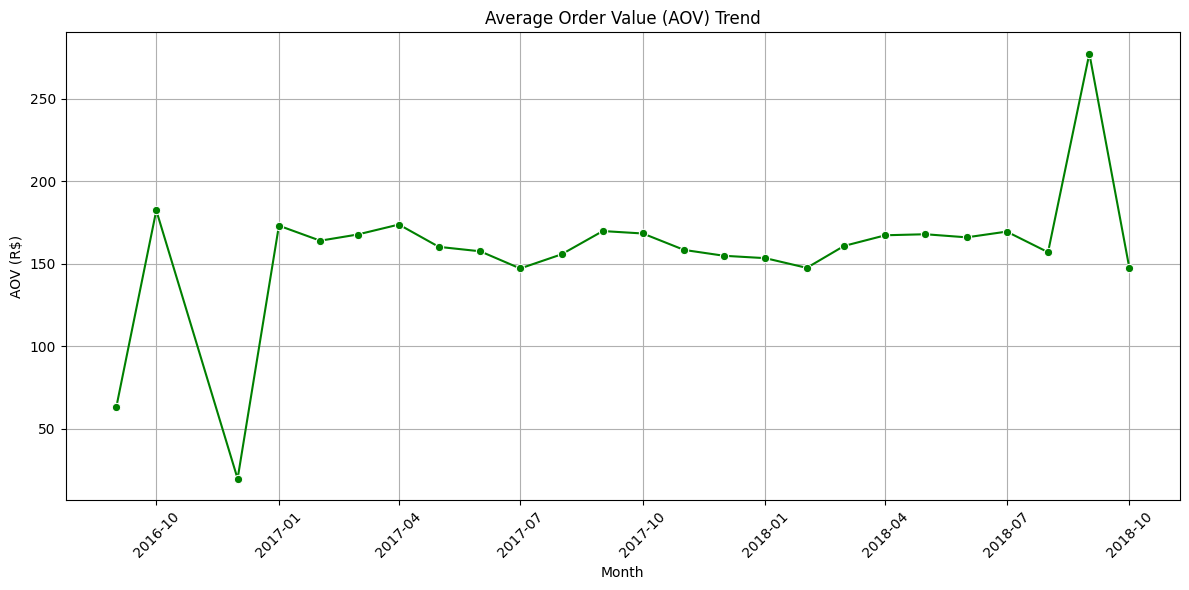

In [13]:
# ============================
# AOV - Step 2
# ============================

# Merge monthly revenue and orders for AOV
monthly_data = pd.merge(monthly_revenue, monthly_orders, on='month')

# Calculate AOV = revenue / total_orders
monthly_data['AOV'] = monthly_data['payment_value'] / monthly_data['total_orders']

# Plot AOV Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x='month', y='AOV', marker='o', color='green')
plt.title('Average Order Value (AOV) Trend')
plt.xlabel('Month')
plt.ylabel('AOV (R$)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


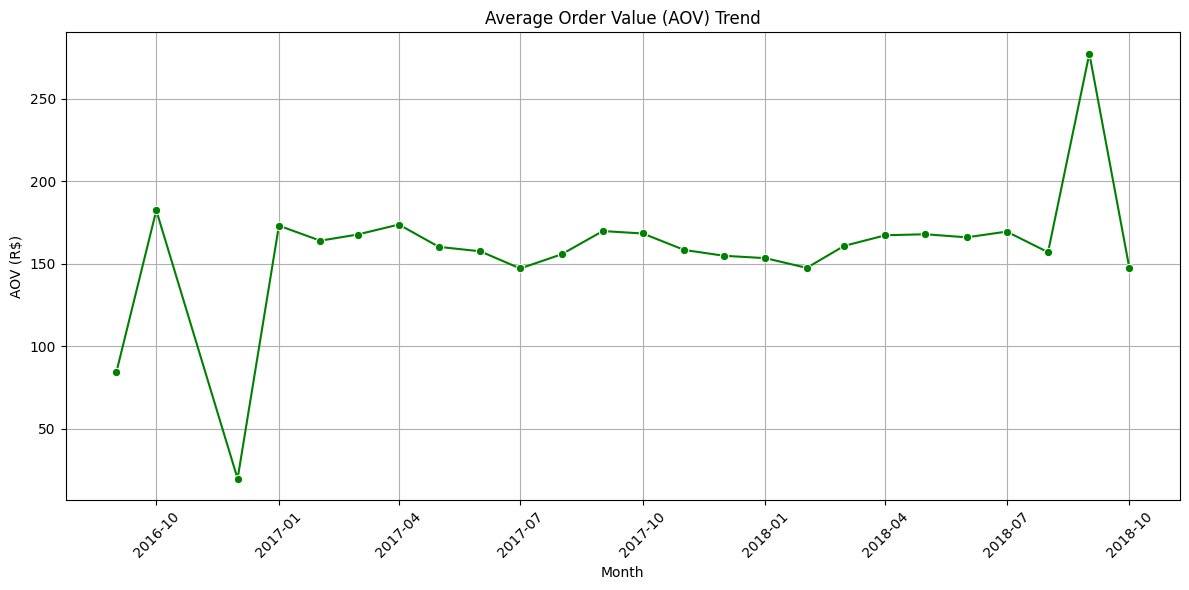

In [14]:
# Extract month from purchase timestamp
orders_payments['month'] = orders_payments['order_purchase_timestamp'].dt.to_period('M')

# Group by month to get total revenue and unique orders
monthly_data = orders_payments.groupby('month').agg({
    'payment_value': 'sum',          # Total revenue per month
    'order_id': 'nunique'            # Total unique orders per month
}).reset_index()

# Convert period to timestamp for plotting
monthly_data['month'] = monthly_data['month'].dt.to_timestamp()

# Calculate AOV (Average Order Value)
monthly_data['AOV'] = monthly_data['payment_value'] / monthly_data['order_id']

# Plot AOV Trend
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_data, x='month', y='AOV', marker='o', color='green')
plt.title('Average Order Value (AOV) Trend')
plt.xlabel('Month')
plt.ylabel('AOV (R$)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Step 1: Merge products with category translations
products = pd.merge(products, category_translation, on='product_category_name', how='left')

# Check result
products[['product_id', 'product_category_name', 'product_category_name_english']].head()


,product_id,product_category_name,product_category_name_english
0,1e9e8ef04dbcff4541ed26657ea517e5,perfumaria,perfumery
1,3aa071139cb16b67ca9e5dea641aaa2f,artes,art
2,96bd76ec8810374ed1b65e291975717f,esporte_lazer,sports_leisure
3,cef67bcfe19066a932b7673e239eb23d,bebes,baby
4,9dc1a7de274444849c219cff195d0b71,utilidades_domesticas,housewares


In [44]:
# Step 1: Merge products with category translations
products = pd.merge(products, category_translation, on='product_category_name', how='left')

# Step 2: Merge order_items with products to get product category
order_product = pd.merge(order_items, products[['product_id', 'product_category_name_english']], on='product_id', how='left')

# Step 3: Merge with payments to get revenue
order_product_payment = pd.merge(order_product, payments[['order_id', 'payment_value']], on='order_id', how='left')

# Check result
order_product_payment[['order_id', 'product_id', 'product_category_name_english', 'payment_value']].head()


,order_id,product_id,product_category_name_english,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,cool_stuff,72.19
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,pet_shop,259.83
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,furniture_decor,216.87
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,perfumery,25.78
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,garden_tools,218.04


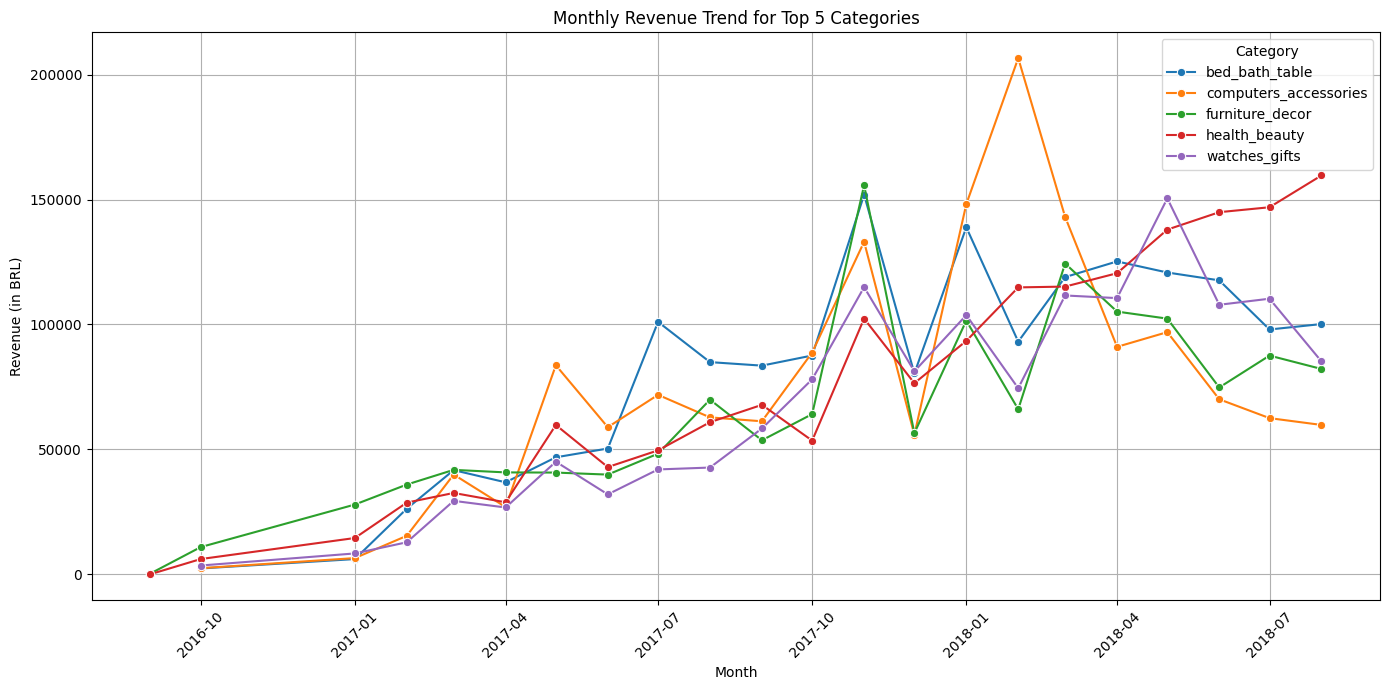

In [45]:
# Merge with orders table to bring timestamp
category_revenue = pd.merge(order_product_payment, orders[['order_id', 'order_purchase_timestamp']], on='order_id', how='left')

# Convert timestamp to datetime format
category_revenue['order_purchase_timestamp'] = pd.to_datetime(category_revenue['order_purchase_timestamp'])

# Extract month

category_revenue['month'] = category_revenue['order_purchase_timestamp'].dt.to_period('M')

# Group by category and month
monthly_category_rev = category_revenue.groupby(['product_category_name_english', 'month'])['payment_value'].sum().reset_index()

# Convert month back to timestamp for plotting
monthly_category_rev['month'] = monthly_category_rev['month'].dt.to_timestamp()

# Get top 5 categories by total revenue
top_categories = monthly_category_rev.groupby('product_category_name_english')['payment_value'].sum().nlargest(5).index

# Filter data for top categories
top_category_data = monthly_category_rev[monthly_category_rev['product_category_name_english'].isin(top_categories)]

# Plotting
plt.figure(figsize=(14, 7))
sns.lineplot(data=top_category_data, x='month', y='payment_value', hue='product_category_name_english', marker='o')
plt.title('Monthly Revenue Trend for Top 5 Categories')
plt.xlabel('Month')
plt.ylabel('Revenue (in BRL)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend(title='Category')
plt.show()


In [ ]:
!pip install statsmodels

In [46]:
# 1. Make sure the month column is datetime
monthly_revenue['month'] = pd.to_datetime(monthly_revenue['month'])

# 2. Set 'month' as index
monthly_revenue.set_index('month', inplace=True)

# 3. Confirm
print(monthly_revenue.index)
print(monthly_revenue.index[-1])
print(type(monthly_revenue.index[-1]))


DatetimeIndex(['2016-09-01', '2016-10-01', '2016-12-01', '2017-01-01',
               '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01',
               '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01',
               '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01',
               '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01'],
              dtype='datetime64[ns]', name='month', freq=None)
2018-10-01 00:00:00
<class 'pandas._libs.tslibs.timestamps.Timestamp'>


C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an ex

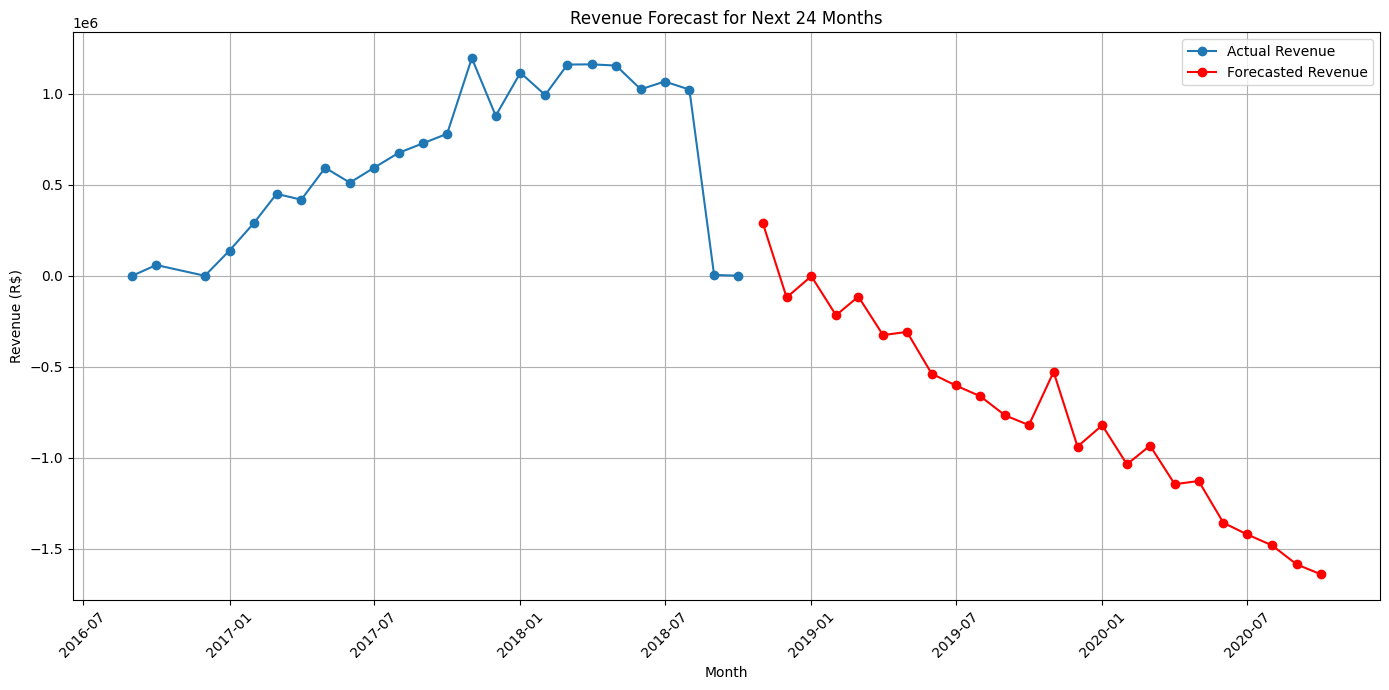

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing


# Fit the Holt-Winters model
model = ExponentialSmoothing(
    monthly_revenue['payment_value'], 
    trend='add', 
    seasonal='add', 
    seasonal_periods=12
)

fit_model = model.fit()

# Forecast next 12 months
forecast_values = fit_model.forecast(24)

# Now create correct future month index
future_dates = pd.date_range(
    start=monthly_revenue.index[-1] + pd.DateOffset(months=1), 
    periods=24, 
    freq='MS'  # MS = Month Start
)

# Assign future dates as index
forecast_values.index = future_dates

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(monthly_revenue.index, monthly_revenue['payment_value'], label='Actual Revenue', marker='o')
plt.plot(forecast_values.index, forecast_values, label='Forecasted Revenue', marker='o', color='red')
plt.title('Revenue Forecast for Next 24 Months')
plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
# 1. Split data
train = monthly_revenue.iloc[:-6]  # Train on all except last 6 months
test = monthly_revenue.iloc[-6:]   # Test on last 6 months

# 2. Fit model on training data
model = ExponentialSmoothing(
    train['payment_value'],
    trend='add',
    seasonal=None,
    seasonal_periods=None
)
fit_model = model.fit()

# 3. Forecast for the test period
forecast_values = fit_model.forecast(len(test))

# 4. Calculate MAE, RMSE
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test['payment_value'], forecast_values)
rmse = np.sqrt(mean_squared_error(test['payment_value'], forecast_values))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\PC\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an ex

MAE: 845699.8509299466
RMSE: 1046226.5715164972


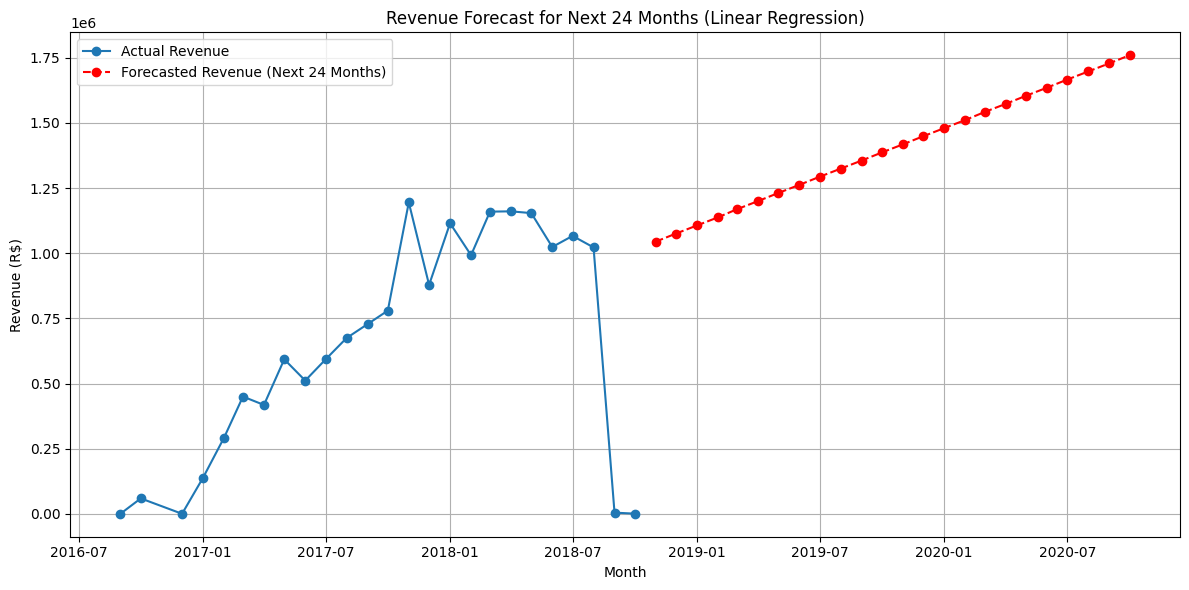

In [49]:

# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 2. Create a copy of your revenue data
revenue_df = monthly_revenue.copy()
revenue_df['month'] = revenue_df.index



# 3. Reset index to bring 'month' back as a normal column
revenue_df = revenue_df.reset_index(drop=True)

# 4. Create a 'time' feature (0,1,2,3... for months)
revenue_df['time'] = np.arange(len(revenue_df))

# 5. Define X (input) and y (target)
X = revenue_df[['time']]
y = revenue_df['payment_value']

# 6. Fit a simple Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X, y)


# 7. Create future 'time' for next 24 months
future_time = pd.DataFrame({
    'time': np.arange(len(revenue_df), len(revenue_df) + 24)
})

# 8. Predict future revenue
forecasted_revenue = lr_model.predict(future_time)

# 9. Create future month dates
future_dates = pd.date_range(
    start=revenue_df['month'].iloc[-1] + pd.DateOffset(months=1),
    periods=24,
    freq='MS'  # Month Start
)

# 10. Create forecast DataFrame
forecast_df = pd.DataFrame({
    'month': future_dates,
    'forecasted_revenue': forecasted_revenue
})

# 11. Plot Actual vs Forecasted Revenue
plt.figure(figsize=(12, 6))
plt.plot(revenue_df['month'], revenue_df['payment_value'], label='Actual Revenue', marker='o')
plt.plot(forecast_df['month'], forecast_df['forecasted_revenue'], label='Forecasted Revenue (Next 24 Months)', linestyle='--', marker='o', color='red')
plt.title('Revenue Forecast for Next 24 Months (Linear Regression)')
plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print(monthly_revenue.index)
print(monthly_revenue.index[-1])
print(type(monthly_revenue.index[-1]))


In [50]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict on training data
y_pred_train = lr_model.predict(X)

# Calculate MAE and RMSE
mae = mean_absolute_error(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")


MAE: 255106.33050892313
RMSE: 358628.4027209112


MAE: 255106.33050892313
RMSE: 358628.4027209112


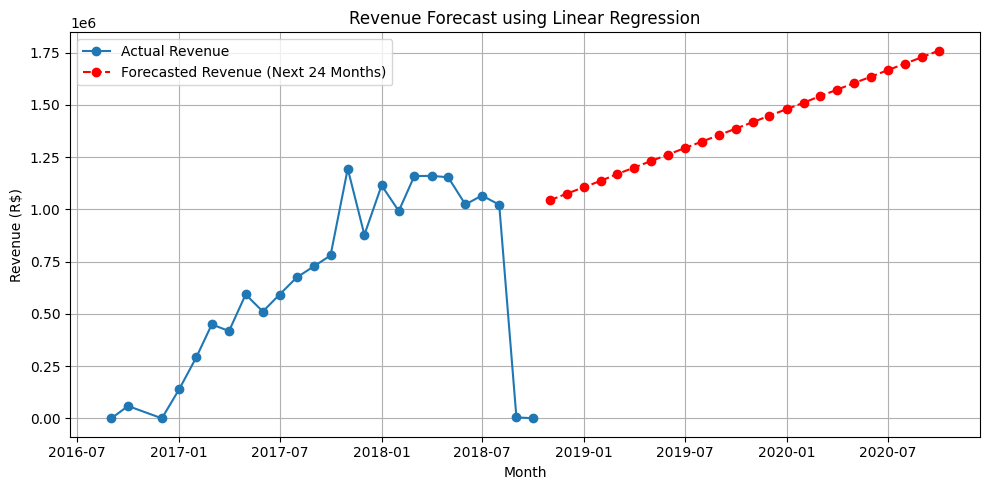

In [52]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 2. Prepare the data
# Assuming your existing dataframe is 'monthly_revenue' with 'month' and 'payment_value'
monthly_revenue = monthly_revenue.reset_index(drop=False)  # pull back month column if it was index

# 3. Create a simple time feature (0,1,2,... for each month)
monthly_revenue['time'] = np.arange(len(monthly_revenue))

# 4. Define X (input) and y (target)
X = monthly_revenue[['time']]     # time as input
y = monthly_revenue['payment_value']  # payment_value as target

# 5. Fit the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X, y)

# 6. Predict on existing data to calculate accuracy
y_pred_train = lr_model.predict(X)

# 7. Calculate MAE and RMSE
mae = mean_absolute_error(y, y_pred_train)
rmse = np.sqrt(mean_squared_error(y, y_pred_train))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

# 8. Create future time for next 24 months
future_time = pd.DataFrame({
    'time': np.arange(len(monthly_revenue), len(monthly_revenue) + 24)
})

# 9. Predict future revenue
forecasted_revenue = lr_model.predict(future_time)

# 10. Generate future dates
future_dates = pd.date_range(
    start=monthly_revenue['month'].iloc[-1] + pd.DateOffset(months=1),
    periods=24,
    freq='MS'
)

# 11. Create a forecast DataFrame
forecast_df = pd.DataFrame({
    'month': future_dates,
    'forecasted_revenue': forecasted_revenue
})

# 12. Plot Actual vs Forecasted Revenue
plt.figure(figsize=(10, 5))
plt.plot(monthly_revenue['month'], monthly_revenue['payment_value'], label='Actual Revenue', marker='o')
plt.plot(forecast_df['month'], forecast_df['forecasted_revenue'], label='Forecasted Revenue (Next 24 Months)', linestyle='--', marker='o', color='red')
plt.title('Revenue Forecast using Linear Regression')
plt.xlabel('Month')
plt.ylabel('Revenue (R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
# Find month with highest revenue
peak_month = monthly_revenue['payment_value'].idxmax()
peak_value = monthly_revenue['payment_value'].max()
# Find month with lowest revenue
dip_month = monthly_revenue['payment_value'].idxmin()
dip_value = monthly_revenue['payment_value'].min()

# First pull the correct month for peak and dip
peak_month_actual = monthly_revenue.loc[peak_month, 'month']
dip_month_actual = monthly_revenue.loc[dip_month, 'month']

# Now print properly
print(f"📈 Peak Month: {peak_month_actual.strftime('%B %Y')} with Revenue: {peak_value:.2f}")
print(f"📉 Dip Month: {dip_month_actual.strftime('%B %Y')} with Revenue: {dip_value:.2f}")


📈 Peak Month: November 2017 with Revenue: 1194882.80
📉 Dip Month: December 2016 with Revenue: 19.62


In [ ]:
print(monthly_orders.head())

monthly_orders.info()

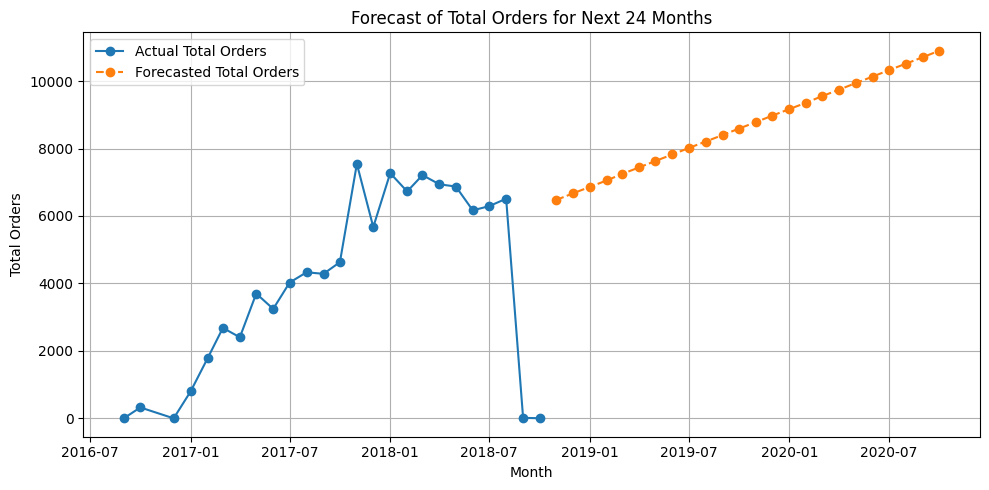

In [55]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# 1. Create a copy
order_forecast_df = monthly_orders.copy()

# 2. Create 'time' feature
order_forecast_df['time'] = np.arange(len(order_forecast_df))

# 3. Define input (X) and target (y)
X = order_forecast_df[['time']]
y = order_forecast_df['total_orders']

# 4. Build Linear Regression Model
model = LinearRegression()
model.fit(X, y)

# 5. Create future time points for next 24 months
future_time = pd.DataFrame({
    'time': np.arange(len(order_forecast_df), len(order_forecast_df) + 24)
})

# 6. Predict future order volume
forecasted_orders = model.predict(future_time)

# 7. Create future dates
future_dates = pd.date_range(
    start=order_forecast_df['month'].iloc[-1] + pd.DateOffset(months=1),
    periods=24,
    freq='MS'
)

# 8. Create forecast DataFrame
forecast_orders_df = pd.DataFrame({
    'month': future_dates,
    'forecasted_total_orders': forecasted_orders
})

# 9. Plot actual vs forecasted
plt.figure(figsize=(10, 5))
plt.plot(order_forecast_df['month'], order_forecast_df['total_orders'], label='Actual Total Orders', marker='o')
plt.plot(forecast_orders_df['month'], forecast_orders_df['forecasted_total_orders'], label='Forecasted Total Orders', linestyle='--', marker='o')
plt.title('Forecast of Total Orders for Next 24 Months')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


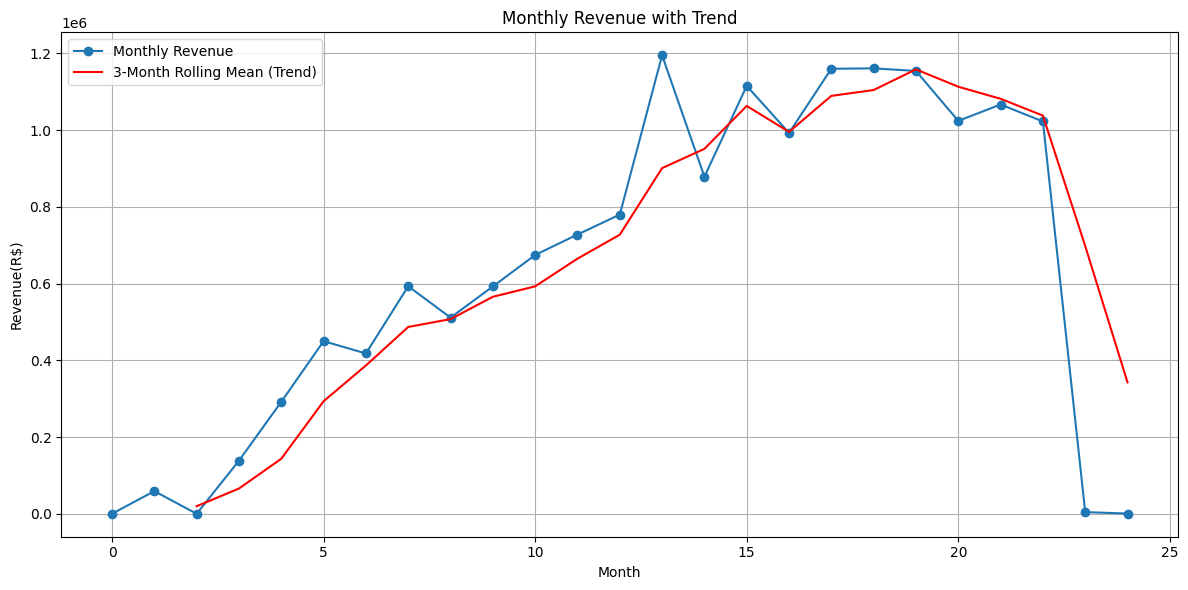

In [56]:
# Trend and Seasonality for Revenue

# Set month as index for better plotting
monthly_revenue_trend = monthly_revenue.copy()


# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_revenue_trend.index, monthly_revenue_trend['payment_value'], label='Monthly Revenue', marker='o')
plt.plot(monthly_revenue_trend['payment_value'].rolling(window=3).mean(), label='3-Month Rolling Mean (Trend)', color='red')
plt.title('Monthly Revenue with Trend')
plt.xlabel('Month')
plt.ylabel('Revenue(R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


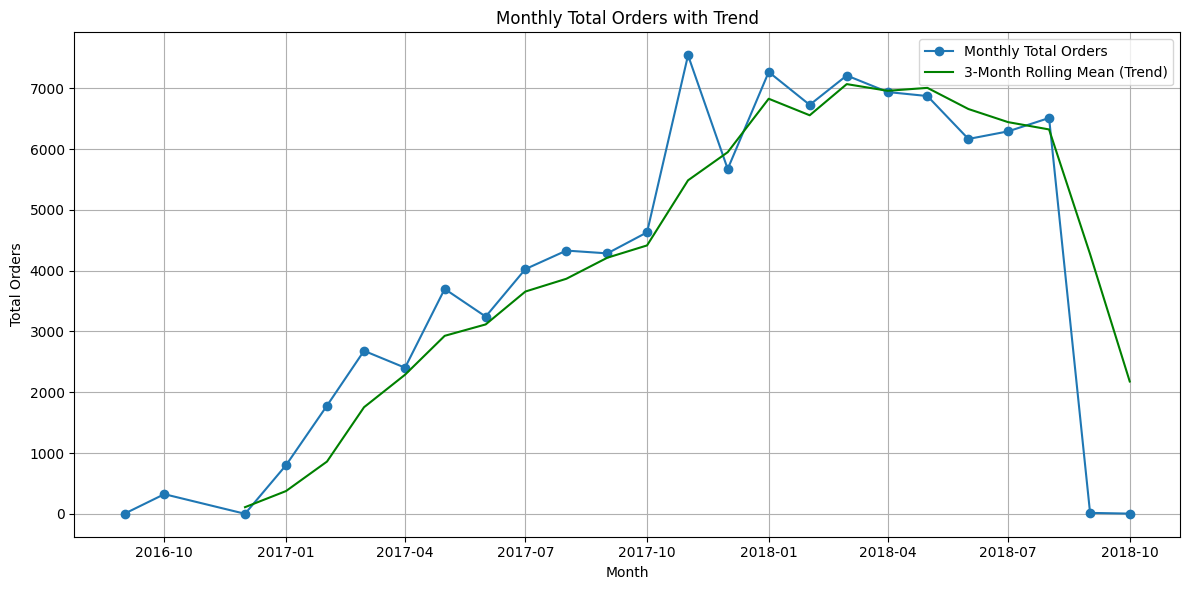

In [57]:
# Trend and Seasonality for Orders

# Set month as index for better plotting
monthly_orders_trend = monthly_orders.copy()
monthly_orders_trend.set_index('month', inplace=True)

# Plot
plt.figure(figsize=(12,6))
plt.plot(monthly_orders_trend.index, monthly_orders_trend['total_orders'], label='Monthly Total Orders', marker='o')
plt.plot(monthly_orders_trend['total_orders'].rolling(window=3).mean(), label='3-Month Rolling Mean (Trend)', color='green')
plt.title('Monthly Total Orders with Trend')
plt.xlabel('Month')
plt.ylabel('Total Orders')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Trend & Seasonality Analysis Summary
1. Revenue Trend:
The monthly revenue showed a strong upward growth trend from early 2017 until mid-2018.

Revenue peaked in November 2017 (~1.19 million) — indicating a major business high point.

Post mid-2018, there was a sharp decline in revenue, particularly visible after September 2018.

The 3-month rolling average smooths out short-term fluctuations, confirming the strong growth phase followed by the sudden drop.

2. Order Volume Trend:
The monthly total orders followed a similar rising trend as revenue, growing consistently throughout 2017 and early 2018.

There were small dips visible (like December 2016), but overall, the number of orders increased steadily.

Order volume peaked around the same time as revenue, after which there is a noticeable fall.

The 3-month rolling average of orders highlights a steady climb until the late phase of 2018 before the drop.

✅ Insight:
Both revenue and order volume grew rapidly until mid/late 2018 and then experienced a sudden decrease, likely due to business seasonality, market conditions, or dataset limitations.

In [59]:
# Step 2: Work on a copy
monthly_category_rev_copy = monthly_category_rev.copy()

# Step 2.1: Find Top 5 categories by total revenue
top_5_categories = (
    monthly_category_rev_copy
    .groupby('product_category_name_english')['payment_value']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

print("Top 5 Categories:")
print(top_5_categories)

# Step 2.2: Filter data only for Top 5 categories
top5_monthly_category_rev = monthly_category_rev_copy[
    monthly_category_rev_copy['product_category_name_english'].isin(top_5_categories)
].reset_index(drop=True)

top5_monthly_category_rev


Top 5 Categories:
Index(['bed_bath_table', 'health_beauty', 'computers_accessories',
       'furniture_decor', 'watches_gifts'],
      dtype='object', name='product_category_name_english')


,product_category_name_english,month,payment_value
0,bed_bath_table,2016-10-01,2291.71
1,bed_bath_table,2017-01-01,6054.91
2,bed_bath_table,2017-02-01,26219.52
3,bed_bath_table,2017-03-01,41668.27
4,bed_bath_table,2017-04-01,36794.55
...,...,...,...
102,watches_gifts,2018-04-01,110564.70
103,watches_gifts,2018-05-01,150509.78
104,watches_gifts,2018-06-01,107896.58
105,watches_gifts,2018-07-01,110321.75



 Forecasting for Category: bed_bath_table


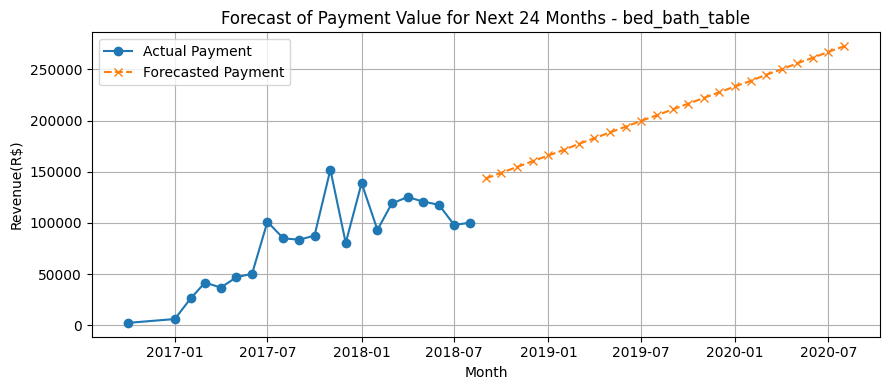


 Forecasting for Category: health_beauty


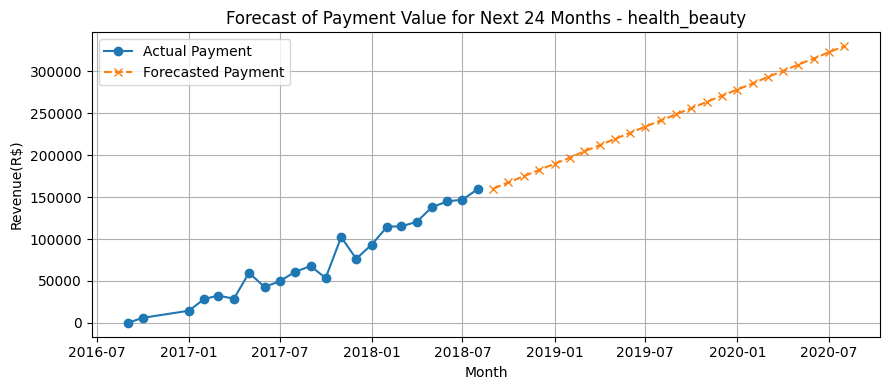


 Forecasting for Category: computers_accessories


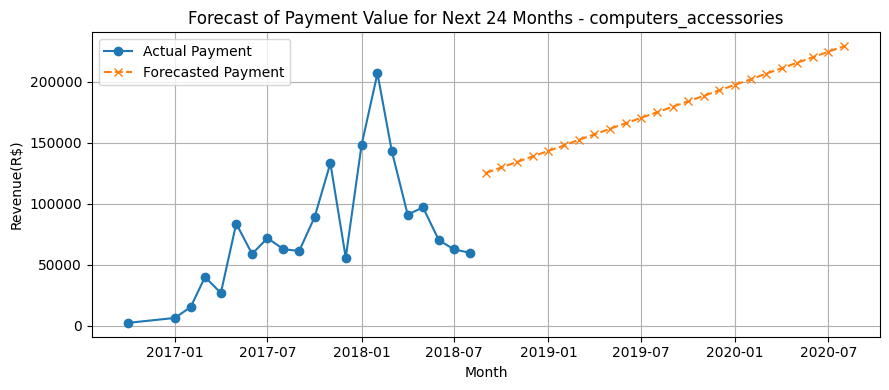


 Forecasting for Category: furniture_decor


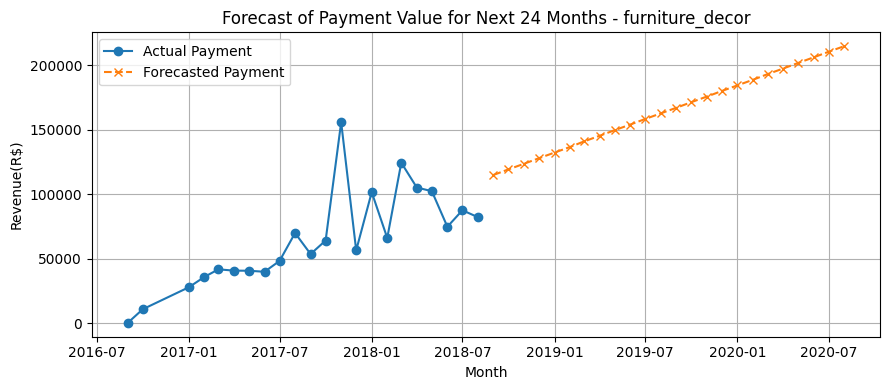


 Forecasting for Category: watches_gifts


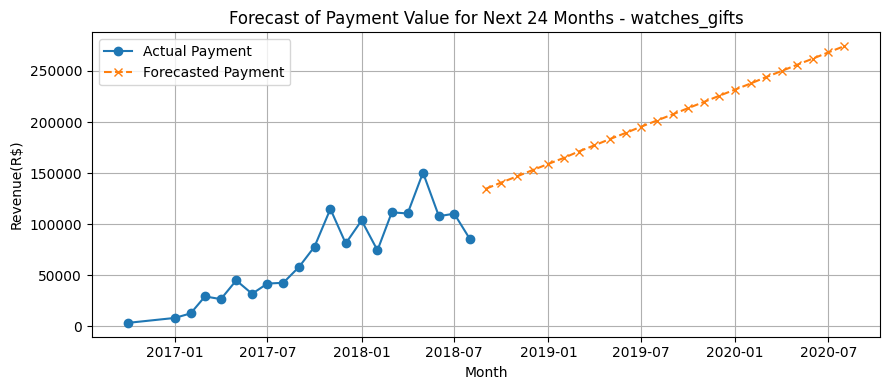

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create a copy for safety
monthly_category_rev_copy = monthly_category_rev.copy()

# Define top categories
top_5_categories = (
    monthly_category_rev_copy
    .groupby('product_category_name_english')['payment_value']
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Loop through each top category
for category in top_5_categories:
    print(f"\n Forecasting for Category: {category}")

    # Filter data for the category
    cat_data = monthly_category_rev_copy[monthly_category_rev_copy['product_category_name_english'] == category].copy()

    # Reset index
    cat_data = cat_data.reset_index(drop=True)

    # Create time feature
    cat_data['time'] = np.arange(len(cat_data))

    # Define X and y
    X = cat_data[['time']]
    y = cat_data['payment_value']

    # Fit Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # Create future time steps
    future_time = pd.DataFrame({
        'time': np.arange(len(cat_data), len(cat_data) + 24)
    })

    # Predict future revenue
    forecasted_payment = model.predict(future_time)

    # Generate future months
    future_months = pd.date_range(
        start=cat_data['month'].iloc[-1] + pd.DateOffset(months=1),
        periods=24,
        freq='MS'
    )

    # Create forecast dataframe
    forecast_df = pd.DataFrame({
        'month': future_months,
        'forecasted_payment_value': forecasted_payment
    })

    # Plot actual vs forecast
    plt.figure(figsize=(9, 4))
    plt.plot(cat_data['month'], cat_data['payment_value'], label='Actual Payment', marker='o')
    plt.plot(forecast_df['month'], forecast_df['forecasted_payment_value'], label='Forecasted Payment', linestyle='--', marker='x')
    plt.title(f"Forecast of Payment Value for Next 24 Months - {category}")
    plt.xlabel('Month')
    plt.ylabel('Revenue(R$)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


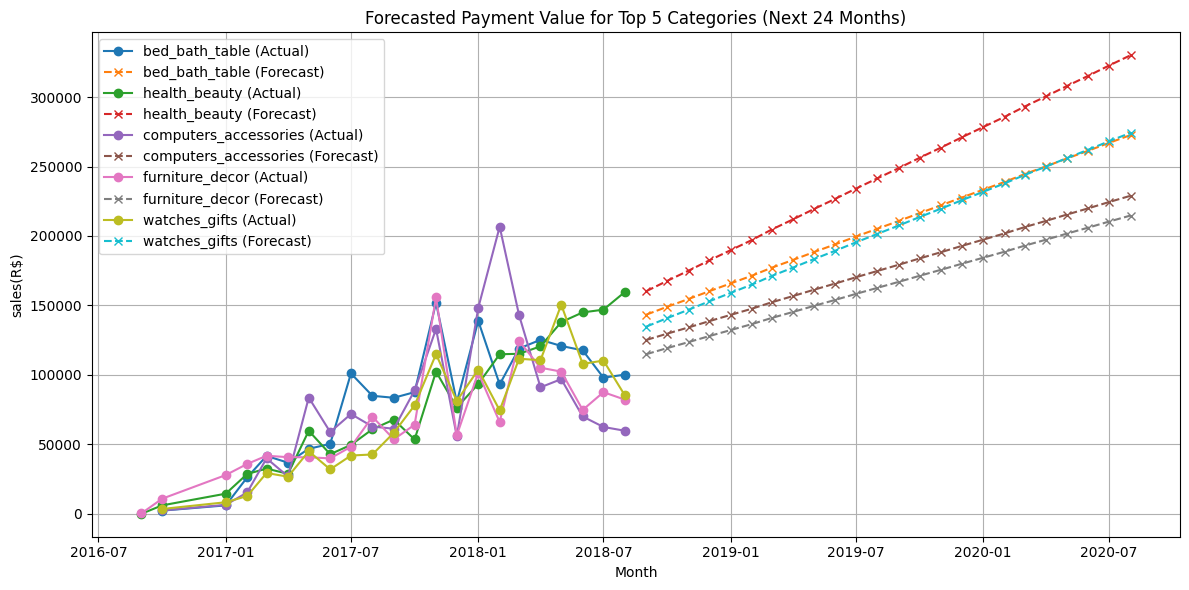

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Create a copy
monthly_category_rev_copy = monthly_category_rev.copy()

# Define Top 5 categories
top_categories = ['bed_bath_table', 'health_beauty', 'computers_accessories', 'furniture_decor', 'watches_gifts']

# Initialize plot
plt.figure(figsize=(12, 6))

# Loop through each top category
for category in top_categories:
    # Filter data for the category
    cat_data = monthly_category_rev_copy[monthly_category_rev_copy['product_category_name_english'] == category].copy()

    # Reset index
    cat_data = cat_data.reset_index(drop=True)

    # Create time feature
    cat_data['time'] = np.arange(len(cat_data))

    # Define X and y
    X = cat_data[['time']]
    y = cat_data['payment_value']

    # Fit Linear Regression model
    model = LinearRegression()
    model.fit(X, y)

    # Create future time steps
    future_time = pd.DataFrame({
        'time': np.arange(len(cat_data), len(cat_data) + 24)
    })

    # Predict future revenue
    forecasted_payment = model.predict(future_time)

    # Generate future months
    future_months = pd.date_range(
        start=cat_data['month'].iloc[-1] + pd.DateOffset(months=1),
        periods=24,
        freq='MS'
    )

    # Plot actual values
    plt.plot(cat_data['month'], cat_data['payment_value'], label=f"{category} (Actual)", marker='o')

    # Plot forecasted values
    plt.plot(future_months, forecasted_payment, linestyle='--', label=f"{category} (Forecast)", marker='x')

# Final plot settings
plt.title('Forecasted Payment Value for Top 5 Categories (Next 24 Months)')
plt.xlabel('Month')
plt.ylabel('sales(R$)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
